In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\fixed_params_var_trials\\v1\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [50]:
save_fig = True

### Load data

In [4]:
with open(dataset_folder + '0_trial_var_tau100ms_alpha0_3_fr3_5hz_len600sec_1000_dict_v1.pkl', 'rb') as f:
    dataset = pickle.load(f)
# trial_dict = trial_dict_full['trial_dict']

n_trials_all = dataset['n_trials']
trial_lens_all = dataset['trial_lens']

In [5]:
with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len pearsonr_trial_avg_dict 1000
len sttc_trial_avg_dict 1000
len sttc_trial_concat_dict 1000


### Make summary dfs

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [ ]:
gen_random_trials_ids = False
if gen_random_trials_ids:
    n_trials_impl = 50
    random_trials_impl_l = []
    for i in range(n_trials_impl):
        random_trials_impl_l.append(random.choices(range(0, 100), k=1000))
    
    with open(results_folder + 'random_trials_impl_50.pkl', "wb") as f:
        pickle.dump(random_trials_impl_l, f)
else:
    with open(results_folder + 'random_trials_impl_50.pkl', "rb") as f:
        random_trials_impl_l = pickle.load(f)

In [9]:
# for trial based measures one realization of trials is taken
use_one_trial_impl = True

if use_one_trial_impl:
    # random_trials_impl = random_trials_impl_l[30]
    random_trials_impl = np.zeros(len(sttc_trial_concat_dict)).astype(int)
    
    pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
    sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
    sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)
else:
    pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg')
    pearsontr_trial_avg_plot_df = pearsontr_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
    
    sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat')
    sttc_trial_concat_plot_df = sttc_trial_concat_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()
    
    sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg')
    sttc_trial_avg_plot_df = sttc_trial_avg_plot_df.groupby(by=['unit_id', 'method'], as_index=False)[['tau_ms','fit_r_squared']].median()

pearsontr_trial_avg_plot_df['n_trials'] = n_trials_all
pearsontr_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
pearsontr_trial_avg_plot_df['tau_ms_true'] = 100
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df['n_trials'] = n_trials_all
sttc_trial_concat_plot_df['trial_len_ms'] = trial_lens_all
sttc_trial_concat_plot_df['tau_ms_true'] = 100
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df['n_trials'] = n_trials_all
sttc_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
sttc_trial_avg_plot_df['tau_ms_true'] = 100
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

N rows with NaNs 56


In [10]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')

N rows with NaNs 56
N rows with NaNs 0
N rows with NaNs 0
N rows in unit_ids_nan_union 56
len pearsonr 944, len sttc_concat 944, len sttc_avg 944


In [11]:
# check for negative R-square

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}, : {unit_ids_negr_union}')

pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')

N rows with neg R 29
N rows with neg R 20
N rows with neg R 26
N rows in unit_ids_negr_union 44, : {np.int64(515), np.int64(772), np.int64(133), np.int64(903), np.int64(524), np.int64(397), np.int64(399), np.int64(17), np.int64(658), np.int64(149), np.int64(407), np.int64(413), np.int64(40), np.int64(433), np.int64(945), np.int64(562), np.int64(566), np.int64(438), np.int64(314), np.int64(956), np.int64(574), np.int64(703), np.int64(704), np.int64(706), np.int64(838), np.int64(582), np.int64(75), np.int64(846), np.int64(977), np.int64(466), np.int64(468), np.int64(86), np.int64(990), np.int64(351), np.int64(356), np.int64(229), np.int64(485), np.int64(103), np.int64(616), np.int64(368), np.int64(886), np.int64(250), np.int64(636), np.int64(253)}
len pearsonr 900, len sttc_concat 900, len sttc_avg 900


In [12]:
tau_plot_long_df = pd.concat([pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df, 
                              sttc_avg_sans_negr_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 2700


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,n_trials,trial_len_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,log_tau_ms
0,0,56532.494471,0.065833,False,pearsonr_trial_avg,2.826625e+06,10,1000,100,2.826525e+06,2.826525e+06,6.451253,6.451268
1,1,1.994014,0.275586,True,pearsonr_trial_avg,9.970071e+01,80,1000,100,2.992948e-01,2.992948e-01,-0.523901,1.998698
2,2,2.526515,0.384218,True,pearsonr_trial_avg,1.263257e+02,70,1000,100,2.632574e+01,2.632574e+01,1.420381,2.101492


### Export for stats

In [13]:
tau_plot_long_df.to_csv(results_folder + 'tau_plot_long_df.csv')

### Plots

In [14]:
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

In [ ]:
# tau_plot_wide_df = acf_full_plot_df.merge(isttc_full_plot_df, suffixes=('_acf', '_isttc'), 
#                                           on=['unit_id','fr', 'alpha', 'tau_ms_true', 'duration_ms', 'duration_s', 'dur_interval'], 
#                                           how='left')
# tau_plot_wide_df.reset_index(inplace=True, drop=True)

# print(f'len tau_plot_wide_df {len(tau_plot_wide_df)}')

# tau_plot_wide_df.columns

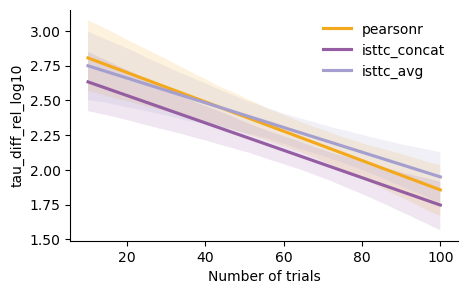

In [49]:
# just to check, I plot the same as predicted values from the model
fig, axes = plt.subplots(1,1, figsize=(5, 3), sharey=False)

sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes, 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes, 
            label='isttc_concat', color=color_sttc_trail_concat)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_avg"'),
            scatter=None, ax=axes, 
            label='isttc_avg', color=color_sttc_trail_avg)
axes.legend(frameon=False)
axes.set_xlabel('Number of trials')

# for ax in axes.flat:
#     ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

In [20]:
tau_plot_long_df.columns

Index(['unit_id', 'tau', 'fit_r_squared', 'decline_150_250', 'method',
       'tau_ms', 'n_trials', 'trial_len_ms', 'tau_ms_true', 'tau_diff_abs',
       'tau_diff_rel', 'tau_diff_rel_log10', 'log_tau_ms'],
      dtype='object')

In [21]:
# intervals for error plots
intervals = {
    '+-100':   (0,   200),
    '+-75':  (25,  175),
    '+-50':  (50,  150),
    '+-25':  (75,  125),
}

tau_3methods_df = tau_plot_long_df[['unit_id', 'method', 'n_trials', 'tau_ms_true', 'tau_ms', 'tau_diff_abs',
       'tau_diff_rel', 'tau_diff_rel_log10', 'log_tau_ms']].copy()
tau_3methods_df.reset_index(inplace=True, drop=True)

df = tau_3methods_df.copy()
rows = []
for method, sub in df.groupby(by=['method','n_trials']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_3methods_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_3methods_error_df = tau_3methods_error_df.reset_index()
tau_3methods_error_long_df = tau_3methods_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)

tau_3methods_error_long_df[['method','n_trials']] = pd.DataFrame(
    tau_3methods_error_long_df['method'].tolist(),
    index=tau_3methods_error_long_df.index
)
tau_3methods_error_long_df = tau_3methods_error_long_df.rename(columns={'interval':'error_interval'})
tau_3methods_error_long_df = tau_3methods_error_long_df[['method','n_trials','error_interval','percentage']]

In [22]:
tau_3methods_error_long_df

,method,n_trials,error_interval,percentage
0,pearsonr_trial_avg,10,+-100,45.652174
1,pearsonr_trial_avg,20,+-100,64.705882
2,pearsonr_trial_avg,30,+-100,75.641026
3,pearsonr_trial_avg,40,+-100,69.863014
4,pearsonr_trial_avg,50,+-100,70.535714
...,...,...,...,...
115,sttc_trial_concat,60,+-25,26.213592
116,sttc_trial_concat,70,+-25,25.000000
117,sttc_trial_concat,80,+-25,26.851852
118,sttc_trial_concat,90,+-25,33.695652


In [33]:
# prep for heatmaps
# ACF
pearsonr_trial_avg = tau_3methods_error_long_df[
    tau_3methods_error_long_df['method']=='pearsonr_trial_avg'
]
pearsonr_trial_avg_pivot = pearsonr_trial_avg.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

# ISTTC
sttc_trial_concat = tau_3methods_error_long_df[
    tau_3methods_error_long_df['method']=='sttc_trial_concat'
]
sttc_trial_concat_pivot = sttc_trial_concat.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

# ISTTC
sttc_trial_avg = tau_3methods_error_long_df[
    tau_3methods_error_long_df['method']=='sttc_trial_avg'
]
sttc_trial_avg_pivot = sttc_trial_avg.pivot(
    index='n_trials',
    columns='error_interval',
    values='percentage'
)

diff_pivot_pearsonr_concat = pearsonr_trial_avg_pivot - sttc_trial_concat_pivot 
diff_pivot_pearsonr_avg = pearsonr_trial_avg_pivot - sttc_trial_avg_pivot

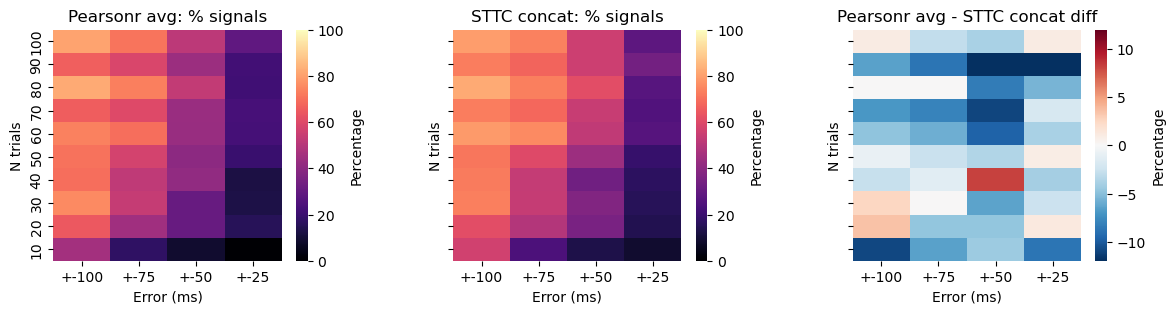

In [51]:
col_order = ['+-100', '+-75', '+-50', '+-25']

row_order = sorted(pearsonr_trial_avg_pivot.index, reverse=True)

pearsonr_trial_avg_ordered  = pearsonr_trial_avg_pivot.reindex(index=row_order, columns=col_order)
sttc_trial_concat_ordered  = sttc_trial_concat_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_pearsonr_concat_pivot_ordered  = diff_pivot_pearsonr_concat.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

diff_limit = np.max([np.abs(diff_pivot_pearsonr_concat_pivot_ordered.min().min()), 
                     np.abs(diff_pivot_pearsonr_concat_pivot_ordered.max().max())])

norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)
#norm = TwoSlopeNorm(vcenter=0)

sns.heatmap(
    pearsonr_trial_avg_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[0]
)
axes[0].set_title("Pearsonr avg: % signals")

sns.heatmap(
    sttc_trial_concat_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[1]
)
axes[1].set_title('STTC concat: % signals')

sns.heatmap(
    diff_pivot_pearsonr_concat_pivot_ordered,
    cmap="RdBu_r", 
    norm=norm,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[2]
)
axes[2].set_title('Pearsonr avg - STTC concat diff')

for ax in axes.flat:
    ax.set_xlabel('Error (ms)')
    ax.set_ylabel('N trials')
    
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_heatmaps.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_concat_heatmaps.svg' , bbox_inches='tight')

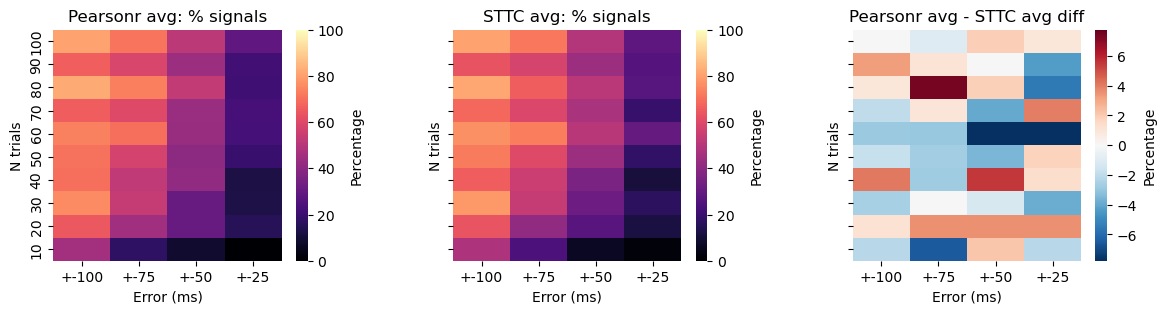

In [52]:
col_order = ['+-100', '+-75', '+-50', '+-25']

row_order = sorted(pearsonr_trial_avg_pivot.index, reverse=True)

pearsonr_trial_avg_ordered  = pearsonr_trial_avg_pivot.reindex(index=row_order, columns=col_order)
sttc_trial_avg_ordered  = sttc_trial_avg_pivot.reindex(index=row_order, columns=col_order)
diff_pivot_pearsonr_avg_pivot_ordered  = diff_pivot_pearsonr_avg.reindex(index=row_order, columns=col_order)

# plot ACF heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

diff_limit = np.max([np.abs(diff_pivot_pearsonr_avg_pivot_ordered.min().min()), 
                     np.abs(diff_pivot_pearsonr_avg_pivot_ordered.max().max())])

norm = TwoSlopeNorm(vcenter=0, vmin=-diff_limit, vmax=diff_limit)
#norm = TwoSlopeNorm(vcenter=0)

sns.heatmap(
    pearsonr_trial_avg_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[0]
)
axes[0].set_title("Pearsonr avg: % signals")

sns.heatmap(
    sttc_trial_avg_ordered,
    cmap="magma", vmin=0, vmax=100,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[1]
)
axes[1].set_title('STTC avg: % signals')

sns.heatmap(
    diff_pivot_pearsonr_avg_pivot_ordered,
    cmap="RdBu_r", 
    norm=norm,
    cbar_kws={'label': 'Percentage'}, 
    ax=axes[2]
)
axes[2].set_title('Pearsonr avg - STTC avg diff')

for ax in axes.flat:
    ax.set_xlabel('Error (ms)')
    ax.set_ylabel('N trials')
    
if save_fig:
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_avg_heatmaps.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_dataset_n_trial_var_p_vs_avg_heatmaps.svg' , bbox_inches='tight')